# Лабораторная 1 - 10 баллов (дедлайн 07.03.2024)
Нужно сгенерировать 3 cлучайных нелинейных регрессии. Для обоих частей задания зафиксировать размерности 2-3х линейных слоев, их активации, функцию потери, lr и оптимизатор, кол-во эпох.

### Первая часть задания:
Протестировать модель только с батчнормом с 3 разными размерами батча.

### Вторая часть:
Протестировать модель с лучшим размером батча из первой части
1) без дропаута и без батчнорма,
2) только с батчнормом без дропаута,
3) только с дропаутом без батчнорма,
4) и с батчнормом и с дропаутом.

### Визуализировать результаты.
### В пару предложений записать выводы.

## Шаг №0 - Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import layers, models
import matplotlib.pyplot as plt

## Шаг №1 - Генерация случайных данных

In [10]:
columns = ["Марка", "Мощность (л.с.)", "Год выпуска", "Пробег (км)", "Кузов", "Тип топлива", "Общая стоимость"]

brands = {
    "Toyota": 1.4, "BMW": 1.7, "Mercedes": 1.7, "Audi": 1.6, "Ford": 1.0,
    "Volkswagen": 1.3, "Hyundai": 1.1, "Nissan": 1.3, "Kia": 1.2, "Mitsubishi": 1.4
}

car_types = {"Седан": 1.0, "Кроссовер": 1.2, "Универсал": 1.3, "Хэтчбек": 0.9, "Купе": 1.1}

fuel_types = { "Бензин": 1.0, "Дизель": 1.1, "Электричество": 1.5}

def price_per_hp(brand, hp, year_built, distance, car_type, fuel_type):
    base_price = 1_000
    power_factor = 1 + 0.02 * hp
    year_factor = 1 + 0.5 * math.exp(-(2025 - year_built) / 40)
    mileage_factor = 1 - 0.3 * math.exp(-distance / 50_000)
    car_type_factor = car_types.get(car_type, 1.0)
    fuel_factor = fuel_types.get(fuel_type, 1.0)
    randomness = random.uniform(0.95, 1.05)

    return round(base_price * brands[brand] * power_factor * year_factor * mileage_factor * car_type_factor * fuel_factor * randomness)

def generate_car_data(n=1000, filename="cars.csv"):
    data = []
    for _ in range(n):
        brand = random.choice(list(brands.keys()))
        hp = random.randint(80, 400)
        year_built = random.randint(1990, 2025)
        distance = random.randint(0, 300_000)
        car_type = random.choice(list(car_types.keys()))
        fuel_type = random.choice(list(fuel_types.keys()))

        price_per_hp_value = price_per_hp(brand, hp, year_built, distance, car_type, fuel_type)
        total_price = price_per_hp_value * hp * (1 + 0.05 * math.log1p(distance / 50_000))

        data.append([brand, hp, year_built, distance, car_type, fuel_type, int(total_price)])

    df = pd.DataFrame(data, columns=columns)
    df.to_csv(filename, index=False, encoding='utf-8')
    print(f"Датасет сохранен в файл {filename}")

generate_car_data(2000)

Датасет сохранен в файл cars.csv


## Шаг №2 - Загрузка данных


In [11]:
df = pd.read_csv("cars.csv")

# Преобразуем категориальные признаки в числовые (используем для этого коэффициенты из словарей)
df['Марка'] = df['Марка'].map(brands)
df['Кузов'] = df['Кузов'].map(car_types)
df['Тип топлива'] = df['Тип топлива'].map(fuel_types)

X = df.drop(columns=["Общая стоимость"])
y = df["Общая стоимость"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

## Шаг №3 - Создание модели

In [12]:
class RegressionModel:
    def __init__(self, input_dim, batch_size, use_batch_norm=False, use_dropout=False, epochs=50):
        """
        Инициализация модели.

        :param input_dim: размерность входных данных
        :param batch_size: размер батча
        :param use_batch_norm: использование батчнорма (True/False)
        :param use_dropout: использование дропаута (True/False)
        :param epochs: количество эпох для обучения
        """
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.epochs = epochs

        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential()
        model.add(layers.Input(shape=(self.input_dim,)))
        model.add(layers.Dense(64, activation='relu'))

        if self.use_batch_norm:
            model.add(layers.BatchNormalization())

        model.add(layers.Dense(32, activation='relu'))

        if self.use_batch_norm:
            model.add(layers.BatchNormalization())
        if self.use_dropout:
            model.add(layers.Dropout(0.3))

        model.add(layers.Dense(1))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def train(self, X_train, y_train, X_test, y_test):
        history = self.model.fit(
            X_train, y_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(X_test, y_test),
            verbose=0
        )
        return history

    def evaluate(self, X_test, y_test):
        loss, mae = self.model.evaluate(X_test, y_test, verbose=0)
        return loss, mae

    def plot_results(self, history, metric='loss'):
        plt.plot(history.history[metric], label=f'Обучение ({metric})')
        plt.plot(history.history[f'val_{metric}'], label=f'Валидация ({metric})')
        plt.title(f'{metric} модели')
        plt.xlabel('Эпохи')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

## Шаг №4 - Обучение модели
### Тестирование модели с батчнормом и разными размерами батча


Обучение с размером батча 32 с батчнормом


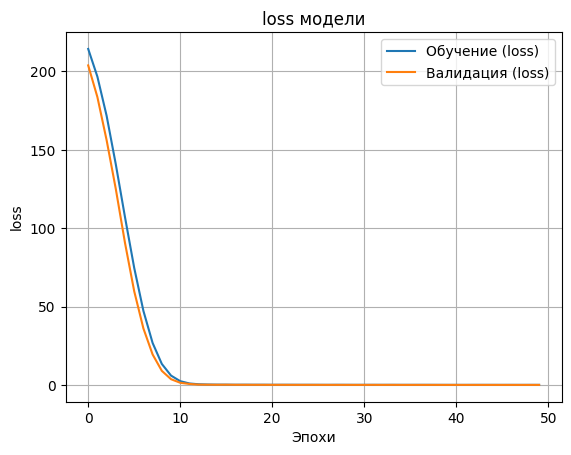

Обучение с размером батча 64 с батчнормом


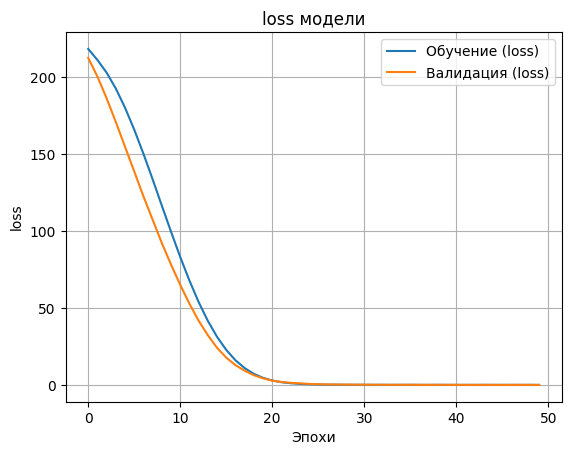

Обучение с размером батча 128 с батчнормом


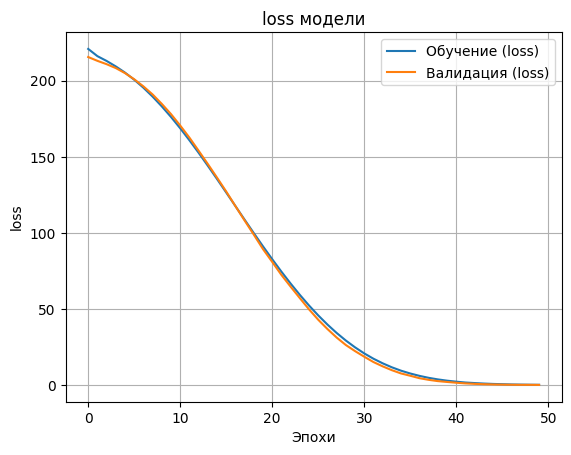

Лучший размер батча: 32 с потерей 0.0355


In [13]:
batch_sizes = [32, 64, 128]
first_part_results = {}
best_loss = float('inf')
best_batch_size = None

for batch_size in batch_sizes:
    print(f"Обучение с размером батча {batch_size} с батчнормом")

    model = RegressionModel(input_dim=X_train.shape[1], batch_size=batch_size, use_batch_norm=True, use_dropout=False, epochs=50)
    history = model.train(X_train, y_train, X_test, y_test)
    val_loss = history.history['val_loss'][-1]

    if val_loss < best_loss:
        best_loss = val_loss
        best_batch_size = batch_size

    first_part_results[f'Batch {batch_size} - BN'] = history
    model.plot_results(history)

print(f"Лучший размер батча: {best_batch_size} с потерей {best_loss:.4f}")

## Шаг №5 - Продолжение обучения модели
### Обучение модели с лучшим размером батча и разными конфигурациями


Обучение с конфигурацией: No BN, No Dropout и батчем 32


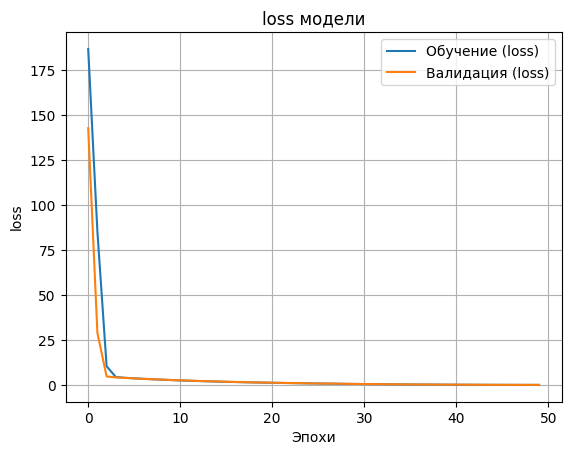

Обучение с конфигурацией: BN, No Dropout и батчем 32


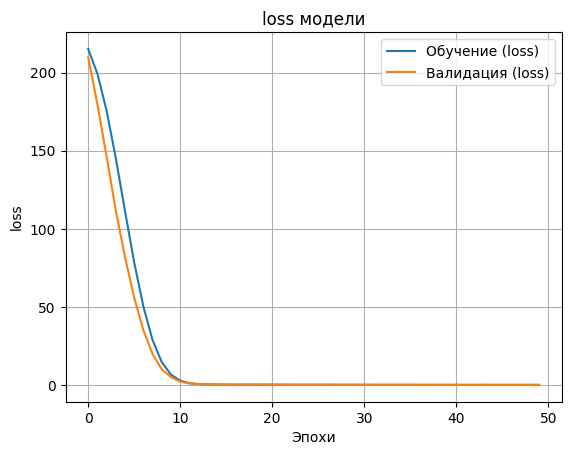

Обучение с конфигурацией: No BN, Dropout и батчем 32


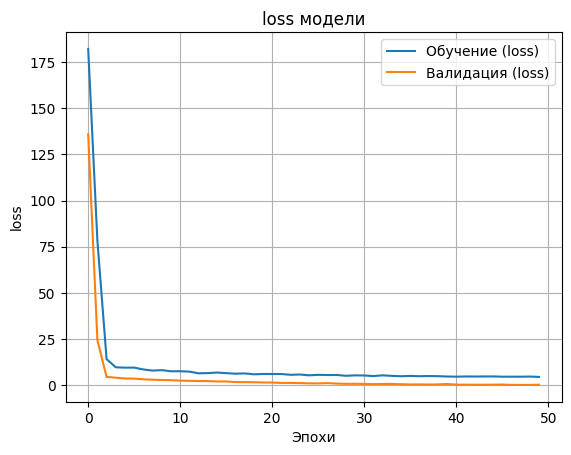

Обучение с конфигурацией: BN, Dropout и батчем 32


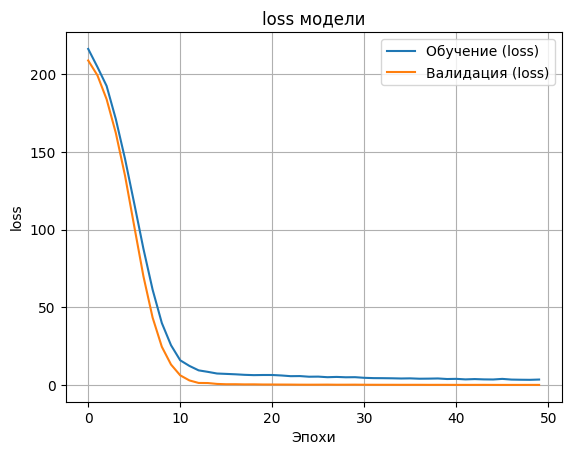

No BN, No Dropout - Batch 32 - MAE: 0.2464
BN, No Dropout - Batch 32 - MAE: 0.1790
No BN, Dropout - Batch 32 - MAE: 0.4925
BN, Dropout - Batch 32 - MAE: 0.2489
Лучшая конфигурация: BN, No Dropout - Batch 32 с MAE: 0.1790


In [16]:
second_part_results = {}

configurations = [
    ("No BN, No Dropout", False, False),
    ("BN, No Dropout", True, False),
    ("No BN, Dropout", False, True),
    ("BN, Dropout", True, True)
]
best_config = None
best_mae = float('inf')

for name, use_bn, use_dropout in configurations:
    print(f"Обучение с конфигурацией: {name} и батчем {best_batch_size}")

    model = RegressionModel(input_dim=X_train.shape[1], batch_size=best_batch_size, use_batch_norm=use_bn, use_dropout=use_dropout)
    history = model.train(X_train, y_train, X_test, y_test)
    second_part_results[f'{name} - Batch {best_batch_size}'] = history
    model.plot_results(history)

for key, history in second_part_results.items():
    mae = history.history['val_mae'][-1]
    if mae < best_mae:
        best_mae = mae
        best_config = key
    print(f'{key} - MAE: {mae:.4f}')

print(f"Лучшая конфигурация: {best_config} с MAE: {best_mae:.4f}")

## Подведение итогов

1) **BatchNormalization значительно улучшает качество обучения:**
    - Использование BatchNormalization приводит к значительному снижению потерь, что объясняется его способностью стабилизировать обучение и ускорять сходимость, улучшая общую производительность модели.
2) **Dropout без BatchNormalization ухудшает результат:**
    - Модель с Dropout, но без BatchNormalization, показала самые высокие потери (MAE ~0.5). Это указывает на то, что в данной задаче слишком агрессивная регуляризация может быть вредной без предварительного стабилизирующего эффекта от BatchNormalization.
3) **Combinations (BatchNormalization + Dropout):**
    - Добавление BatchNormalization и Dropout дает сбалансированный результат, но все-таки использование только BatchNormalization оказалось более эффективным для данной задачи.
    - Dropout может быть полезен в некоторых случаях для предотвращения переобучения, но в сочетании с BatchNormalization его влияние оказывается менее значительным.